# <a name="0">Default of Credit Card Clients</a>

#### In this notebook, we will build, train, tune, and evaluate ML model to predict if the client will default the payment or not.

#### Here are the main steps we will go through:

<a href="#1">1.Get the data</a><br>
<a href="#2">2.Discover and visualize the data to gain insights</a><br>
<a href="#3">3.Prepare the data for Machine Learning algorithms</a><br>
<a href="#4">4.Select a model and train it</a><br>
<a href="#5">5.Fine-tune your model</a><br>
<a href="#6">6.Deploy the new trained model</a><br>


In [1]:
# modules we'll use

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.impute import KNNImputer
from sklearn import preprocessing

In [3]:
import boto3
import sagemaker
import re
import os
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from sagemaker.predictor import CSVSerializer
from sagemaker.tuner import HyperparameterTuner

## <a name="1">1. Get the data</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [4]:
clients = pd.read_excel("default of credit card clients.xls", header=1)
print('The shape of the dataset is:', clients.shape)

The shape of the dataset is: (30000, 25)


## <a name="2">2. Discover and visualize the data to gain insights</a>
(<a href="#0">Go to top</a>)

**This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients from April 2005 to September 2005 (Kaggle Data Set).**

**ID**: ID of each client<br>
**LIMIT_BAL**: Amount of given credit in NT dollars<br>
**SEX**: Gender (1=male, 2=female)<br>
**EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others)<br>
**MARRIAGE**: Marital status (1=married, 2=single, 3=others)<br>
**AGE**: Age in years<br>
**PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)<br>
**PAY_2**: Repayment status in August, 2005 (scale same as above)<br>
**PAY_3**: Repayment status in July, 2005 (scale same as above)<br>
**PAY_4**: Repayment status in June, 2005 (scale same as above)<br>
**PAY_5**: Repayment status in May, 2005 (scale same as above)<br>
**PAY_6**: Repayment status in April, 2005 (scale same as above)<br>
**BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)<br>
**BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)<br>
**BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)<br>
**BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)<br>
**BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)<br>
**BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)<br>
**PAY_AMT1**: Amount of previous payment in September, 2005 (NT dollar)<br>
**PAY_AMT2**: Amount of previous payment in August, 2005 (NT dollar)<br>
**PAY_AMT3**: Amount of previous payment in July, 2005 (NT dollar)<br>
**PAY_AMT4**: Amount of previous payment in June, 2005 (NT dollar)<br>
**PAY_AMT5**: Amount of previous payment in May, 2005 (NT dollar)<br>
**PAY_AMT6**: Amount of previous payment in April, 2005 (NT dollar)<br>
**default payment next month**: Default payment (1=yes, 0=no)

In [5]:
pd.options.display.max_columns = None

In [6]:
clients.head(10)

ID  LIMIT_BAL     SEX        EDUCATION MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0   1      20000  female       university  married   24      2      2     -1   
1   2     120000  female       university   single   26     -1      2      0   
2   3      90000  female       university   single   34      0      0      0   
3   4      50000  female       university  married   37      0      0      0   
4   5      50000    male       university  married   57     -1      0     -1   
5   6      50000    male  graduate school   single   37      0      0      0   
6   7     500000    male  graduate school   single   29      0      0      0   
7   8     100000  female       university   single   23      0     -1     -1   
8   9     140000  female           others  married   28      0      0      2   
9  10      20000    male      high school   single   35     -2     -2     -2   

   PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -1     -2     -2       3913       3102        689          0          0   
1      0      0      2       2682       1725       2682       3272       3455   
2      0      0      0      29239      14027      13559      14331      14948   
3      0      0      0      46990      48233      49291      28314      28959   
4      0      0      0       8617       5670      35835      20940      19146   
5      0      0      0      64400      57069      57608      19394      19619   
6      0      0      0     367965     412023     445007     542653     483003   
7      0      0     -1      11876        380        601        221       -159   
8      0      0      0      11285      14096      12108      12211      11793   
9     -2     -1     -1          0          0          0          0      13007   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   
5      20024      2500      1815       657      1000      1000       800   
6     473944     55000     40000     38000     20239     13750     13770   
7        567       380       601         0       581      1687      1542   
8       3719      3329         0       432      1000      1000      1000   
9      13912         0         0         0     13007      1122         0   

   default payment next month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0  
5                           0  
6                           0  
7                           0  
8                           0  
9                           0

In [7]:
print('The shape of the dataset is:', clients.shape)

The shape of the dataset is: (30000, 25)


In [8]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  int64 
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  object
 3   EDUCATION                   29669 non-null  object
 4   MARRIAGE                    29677 non-null  object
 5   AGE                         30000 non-null  int64 
 6   PAY_0                       30000 non-null  int64 
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

In [9]:
clients.nunique()

ID                            30000
LIMIT_BAL                        81
SEX                               2
EDUCATION                         5
MARRIAGE                          3
AGE                              63
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT4                       6937
PAY_AMT5                       6897
PAY_AMT6                       6939
default payment next month        2
dtype: int64

In [10]:
clients.isnull().sum(axis = 0)

ID                              0
LIMIT_BAL                       0
SEX                             0
EDUCATION                     331
MARRIAGE                      323
AGE                             0
PAY_0                           0
PAY_2                           0
PAY_3                           0
PAY_4                           0
PAY_5                           0
PAY_6                           0
BILL_AMT1                       0
BILL_AMT2                       0
BILL_AMT3                       0
BILL_AMT4                       0
BILL_AMT5                       0
BILL_AMT6                       0
PAY_AMT1                        0
PAY_AMT2                        0
PAY_AMT3                        0
PAY_AMT4                        0
PAY_AMT5                        0
PAY_AMT6                        0
default payment next month      0
dtype: int64

In [11]:
# Frequency tables for each categorical feature
for column in clients.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=clients[column], columns='% observations', normalize='columns')*100)
    
display(pd.crosstab(index=clients['default payment next month'], columns='% observations', normalize='columns')*100)

col_0   % observations
SEX                   
female       60.373333
male         39.626667

col_0            % observations
EDUCATION                      
0                      0.047187
graduate school       35.676969
high school           16.569483
others                 0.417945
university            47.288416

col_0     % observations
MARRIAGE                
0               0.181959
married        46.025542
single         53.792499

col_0                       % observations
default payment next month                
0                                    77.88
1                                    22.12

ID


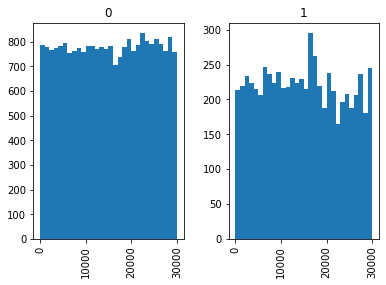

LIMIT_BAL


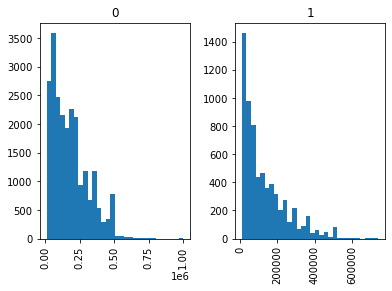

AGE


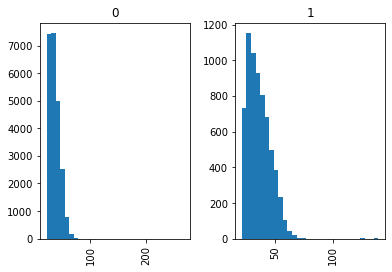

PAY_0


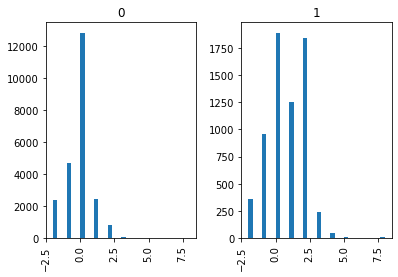

PAY_2


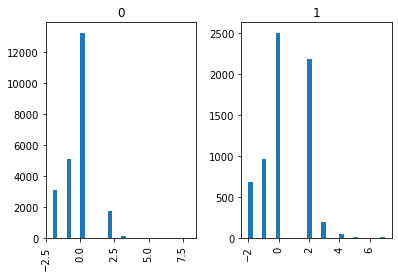

PAY_3


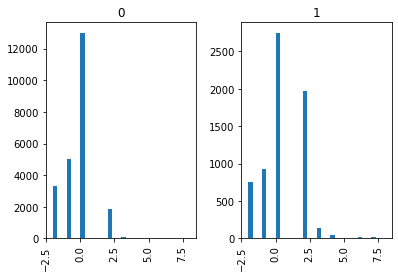

PAY_4


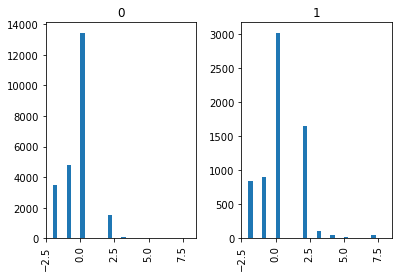

PAY_5


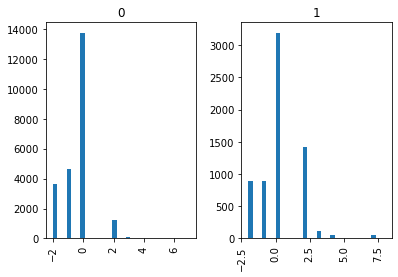

PAY_6


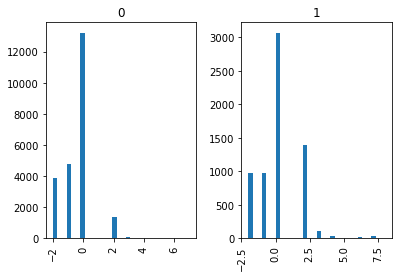

BILL_AMT1


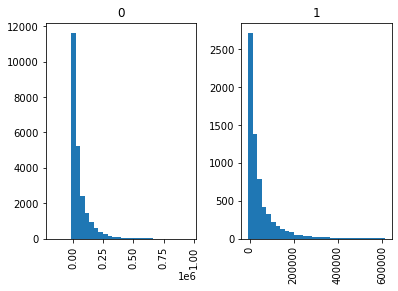

BILL_AMT2


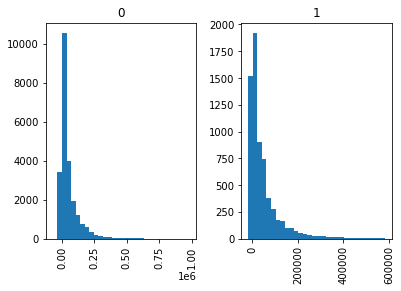

BILL_AMT3


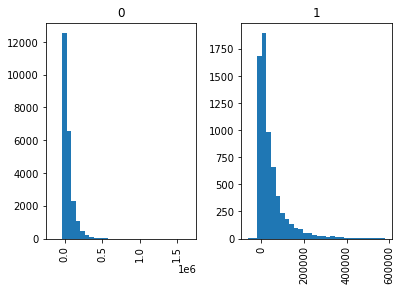

BILL_AMT4


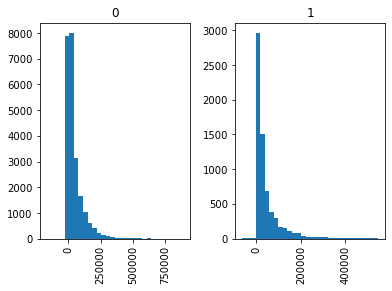

BILL_AMT5


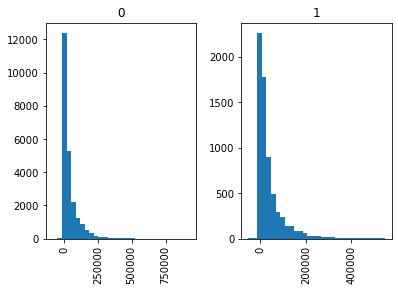

BILL_AMT6


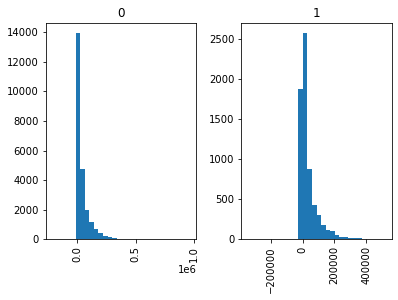

PAY_AMT1


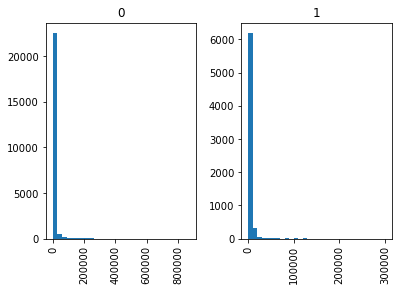

PAY_AMT2


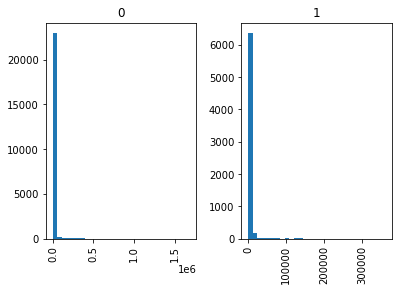

PAY_AMT3


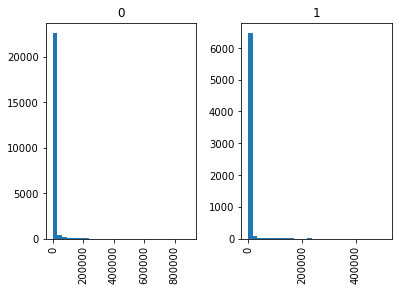

PAY_AMT4


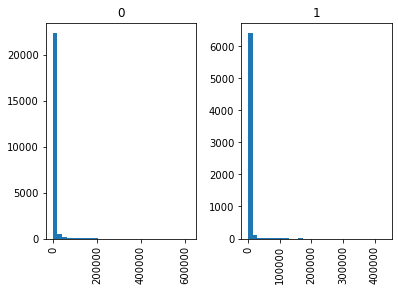

PAY_AMT5


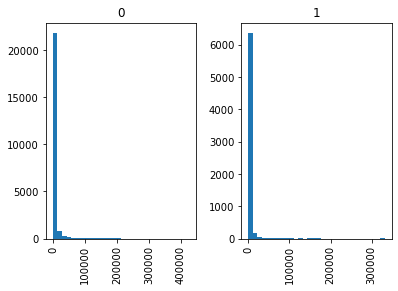

PAY_AMT6


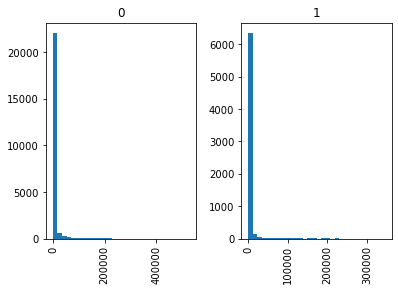

In [12]:
for column in clients.drop(columns=['default payment next month']).select_dtypes(exclude=['object']):
    print(column) 
    hist = clients[[column,'default payment next month']].hist(by='default payment next month', column=column, bins=30, sharey=False) 
    plt.show() 

In [13]:
clients.describe()

ID       LIMIT_BAL           AGE         PAY_0         PAY_2  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667     35.518833     -0.016700     -0.133767   
std     8660.398374   129747.661567      9.528019      1.123802      1.197186   
min        1.000000    10000.000000     21.000000     -2.000000     -2.000000   
25%     7500.750000    50000.000000     28.000000     -1.000000     -1.000000   
50%    15000.500000   140000.000000     34.000000      0.000000      0.000000   
75%    22500.250000   240000.000000     41.000000      0.000000      0.000000   
max    30000.000000  1000000.000000    267.000000      8.000000      8.000000   

              PAY_3         PAY_4         PAY_5         PAY_6      BILL_AMT1  \
count  30000.000000  30000.000000  30000.000000  30000.000000   30000.000000   
mean      -0.166200     -0.220667     -0.266200     -0.291100   51223.330900   
std        1.196868      1.169139      1.133187      1.149988   73635.860576   
min       -2.000000     -2.000000     -2.000000     -2.000000 -165580.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000    3558.750000   
50%        0.000000      0.000000      0.000000      0.000000   22381.500000   
75%        0.000000      0.000000      0.000000      0.000000   67091.000000   
max        8.000000      8.000000      8.000000      8.000000  964511.000000   

           BILL_AMT2     BILL_AMT3      BILL_AMT4      BILL_AMT5  \
count   30000.000000  3.000000e+04   30000.000000   30000.000000   
mean    49179.075167  4.701315e+04   43262.948967   40311.400967   
std     71173.768783  6.934939e+04   64332.856134   60797.155770   
min    -69777.000000 -1.572640e+05 -170000.000000  -81334.000000   
25%      2984.750000  2.666250e+03    2326.750000    1763.000000   
50%     21200.000000  2.008850e+04   19052.000000   18104.500000   
75%     64006.250000  6.016475e+04   54506.000000   50190.500000   
max    983931.000000  1.664089e+06  891586.000000  927171.000000   

           BILL_AMT6       PAY_AMT1      PAY_AMT2      PAY_AMT3  \
count   30000.000000   30000.000000  3.000000e+04   30000.00000   
mean    38871.760400    5663.580500  5.921163e+03    5225.68150   
std     59554.107537   16563.280354  2.304087e+04   17606.96147   
min   -339603.000000       0.000000  0.000000e+00       0.00000   
25%      1256.000000    1000.000000  8.330000e+02     390.00000   
50%     17071.000000    2100.000000  2.009000e+03    1800.00000   
75%     49198.250000    5006.000000  5.000000e+03    4505.00000   
max    961664.000000  873552.000000  1.684259e+06  896040.00000   

            PAY_AMT4       PAY_AMT5       PAY_AMT6  default payment next month  
count   30000.000000   30000.000000   30000.000000                30000.000000  
mean     4826.076867    4799.387633    5215.502567                    0.221200  
std     15666.159744   15278.305679   17777.465775                    0.415062  
min         0.000000       0.000000       0.000000                    0.000000  
25%       296.000000     252.500000     117.750000                    0.000000  
50%      1500.000000    1500.000000    1500.000000                    0.000000  
75%      4013.250000    4031.500000    4000.000000                    0.000000  
max    621000.000000  426529.000000  528666.000000                    1.000000

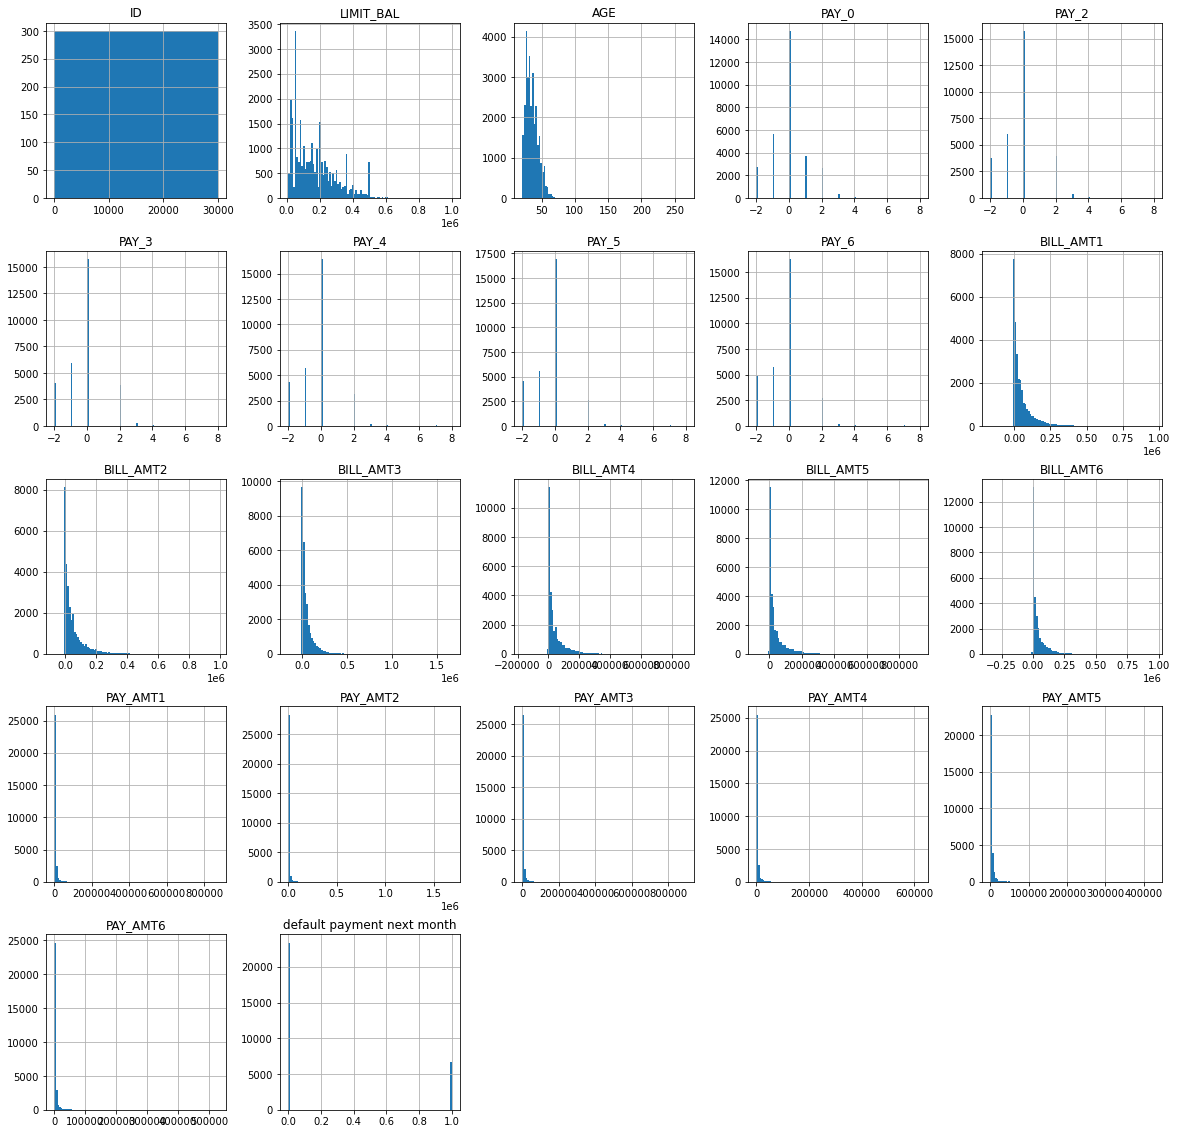

In [14]:
hist = clients.hist(bins=100, sharey=False, figsize=(20,20))

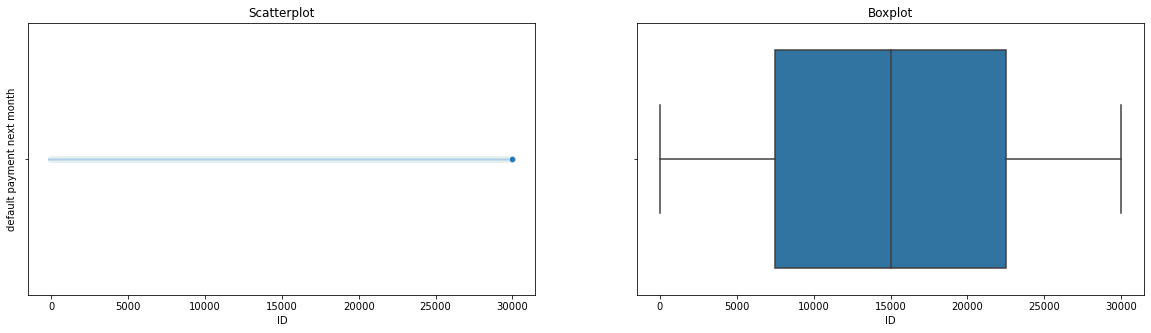

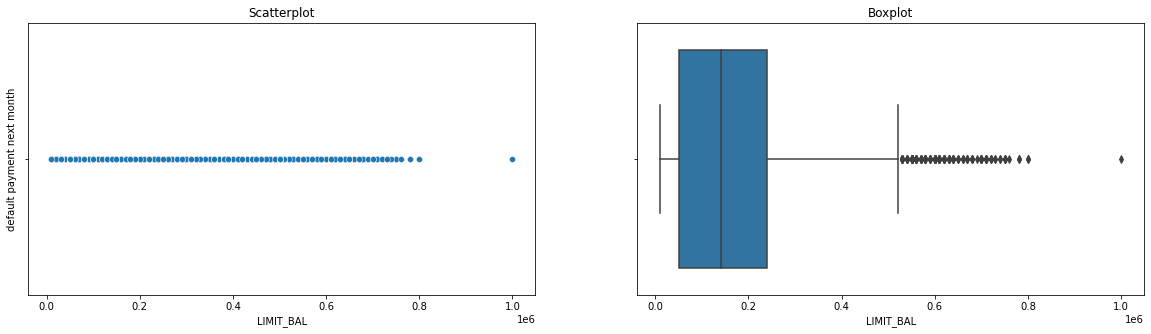

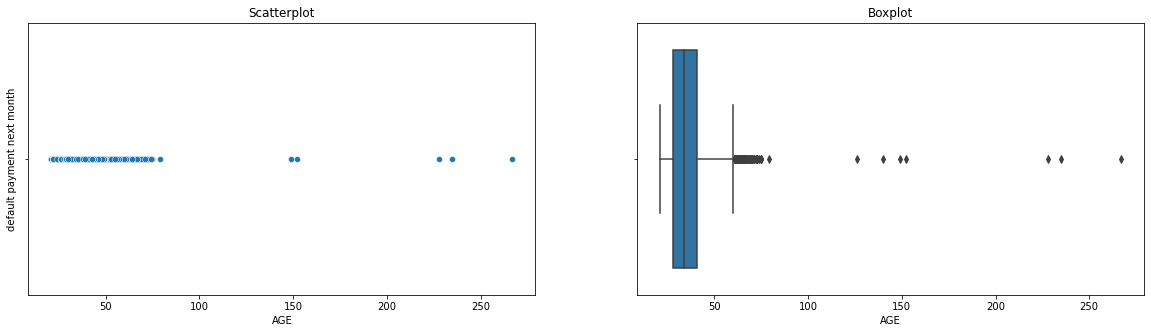

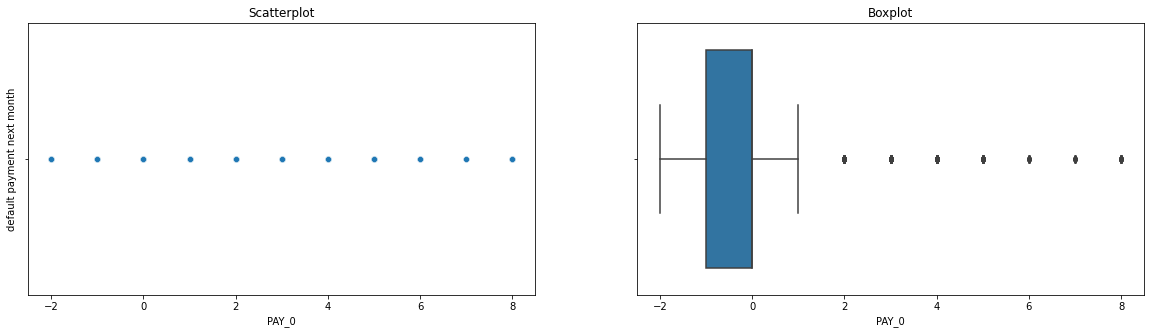

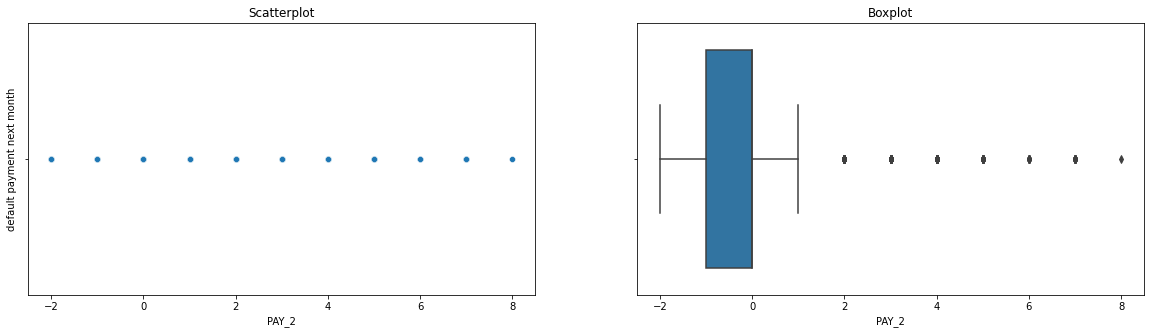

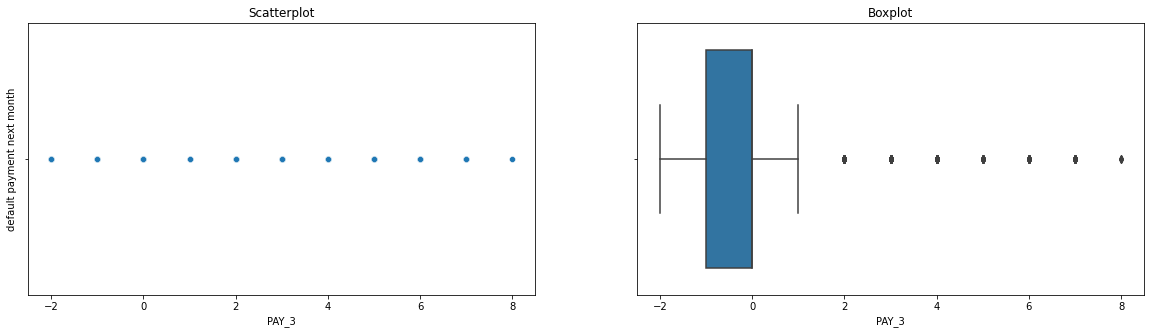

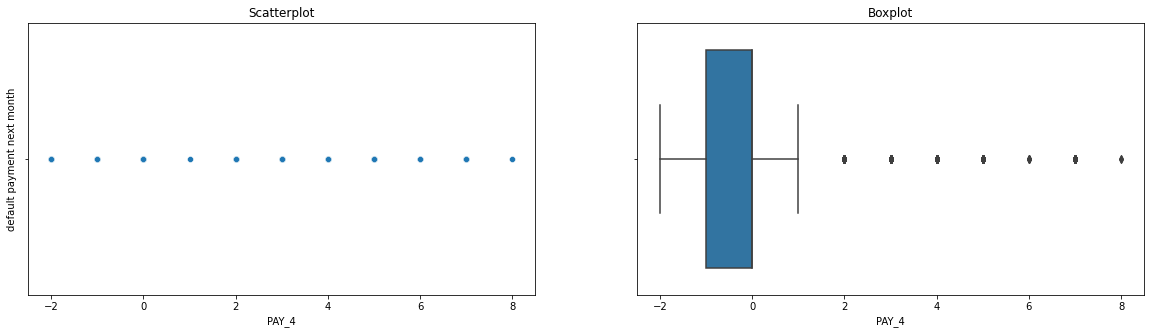

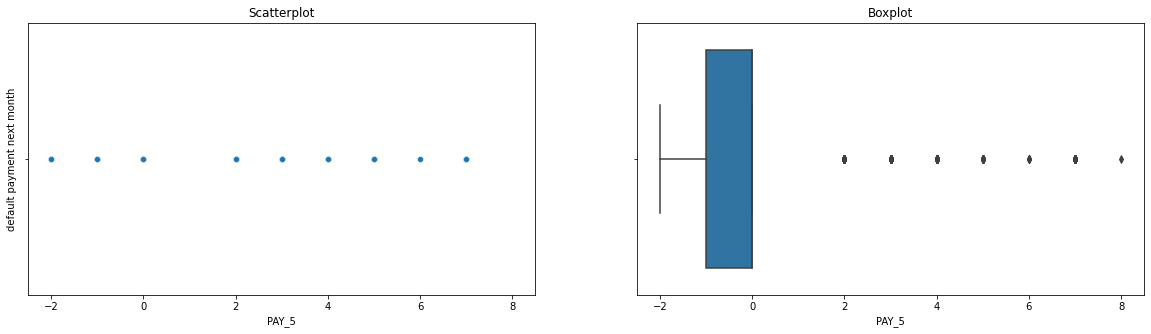

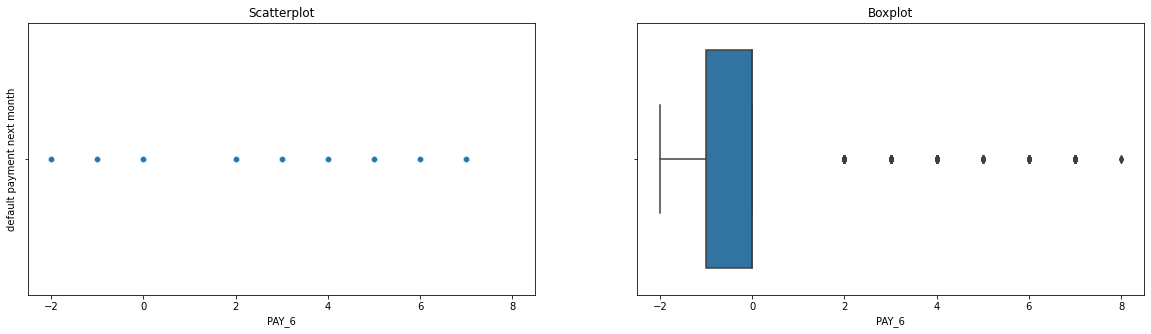

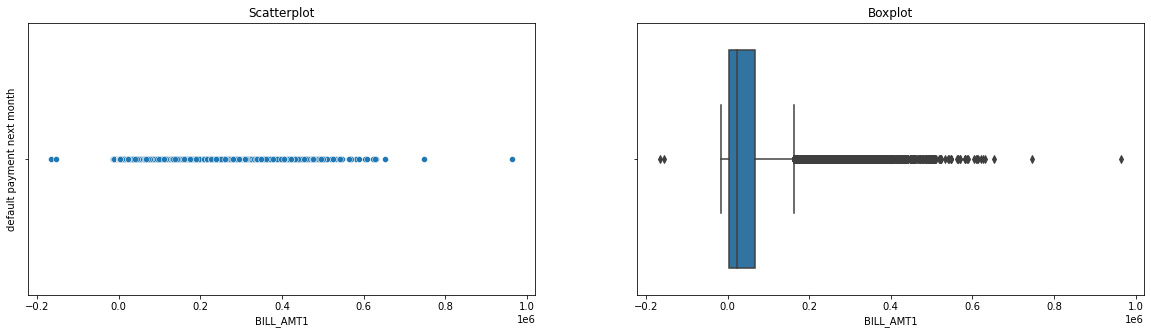

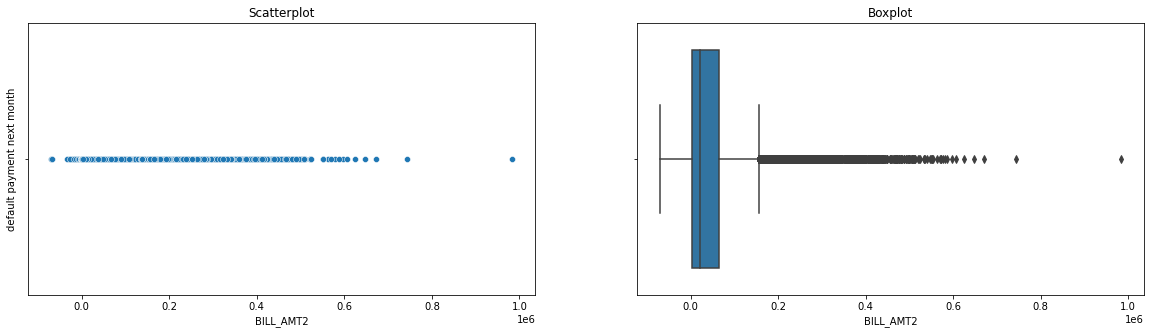

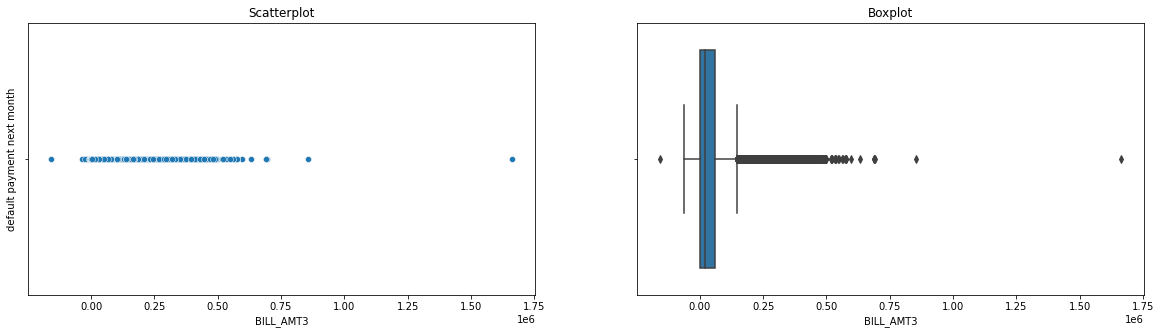

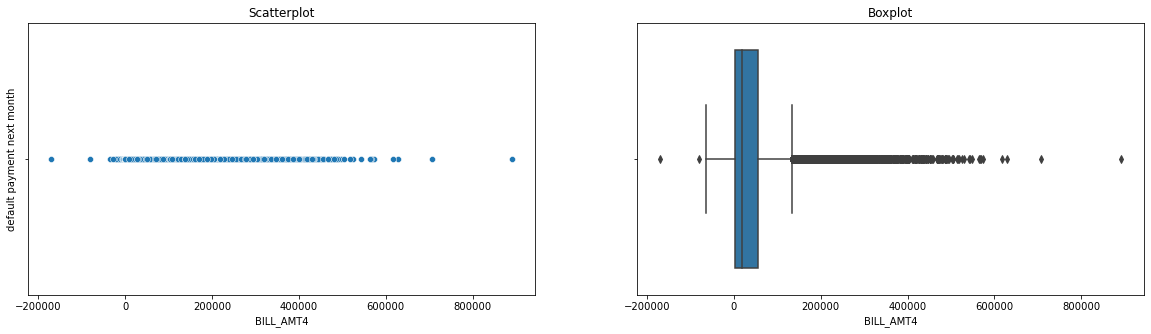

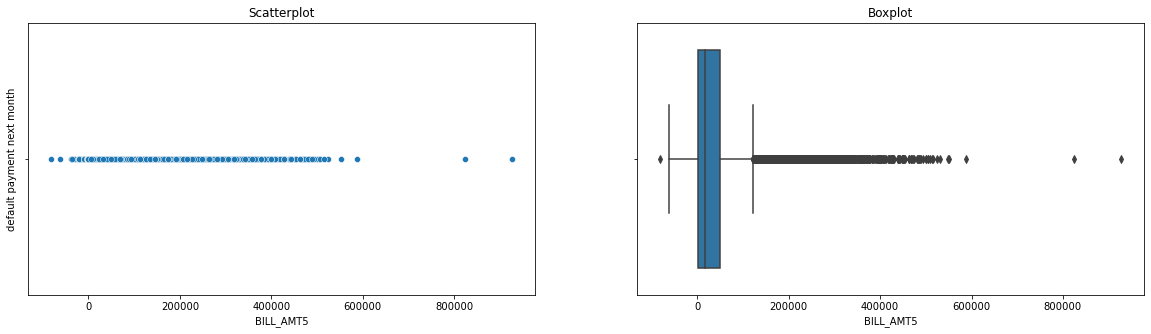

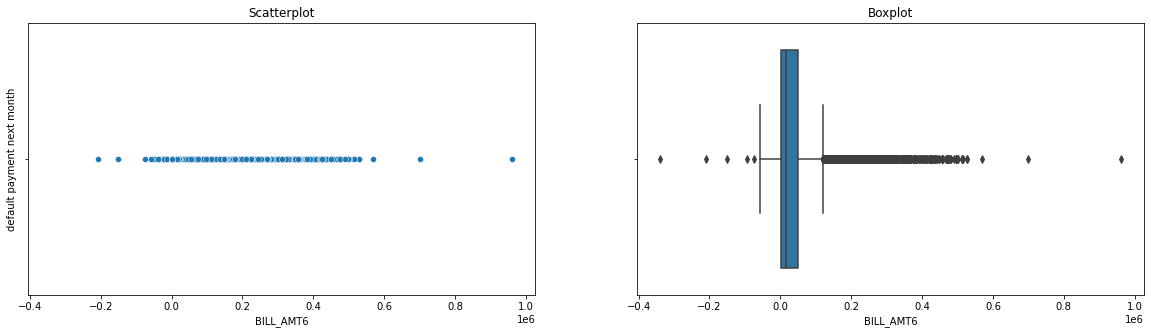

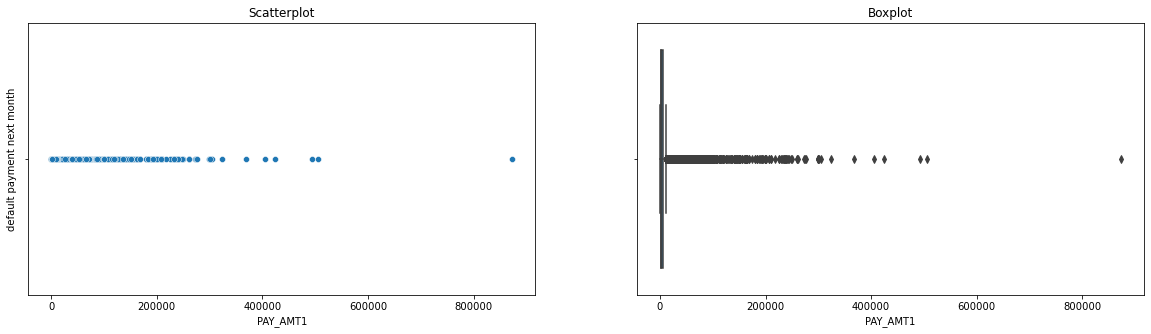

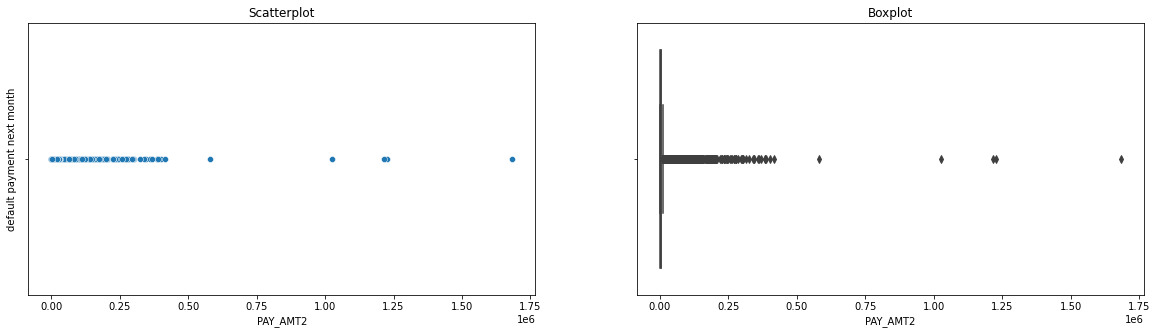

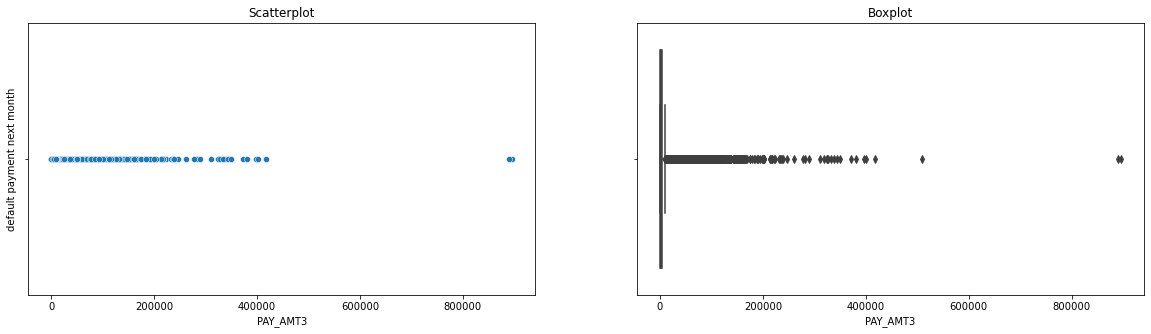

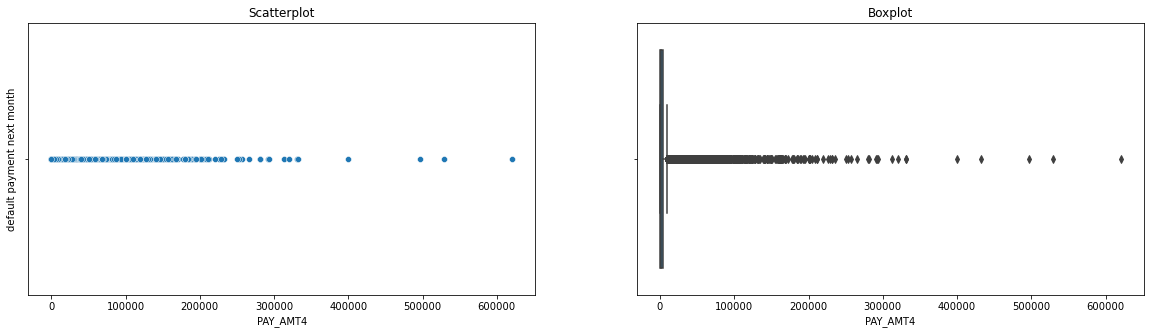

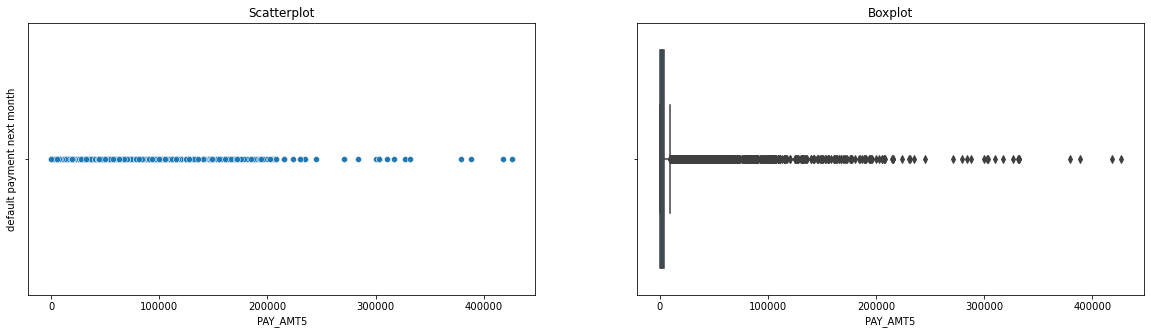

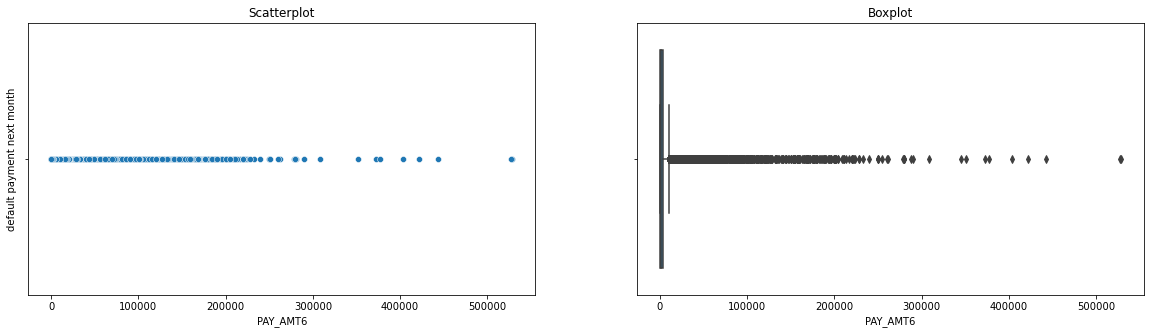

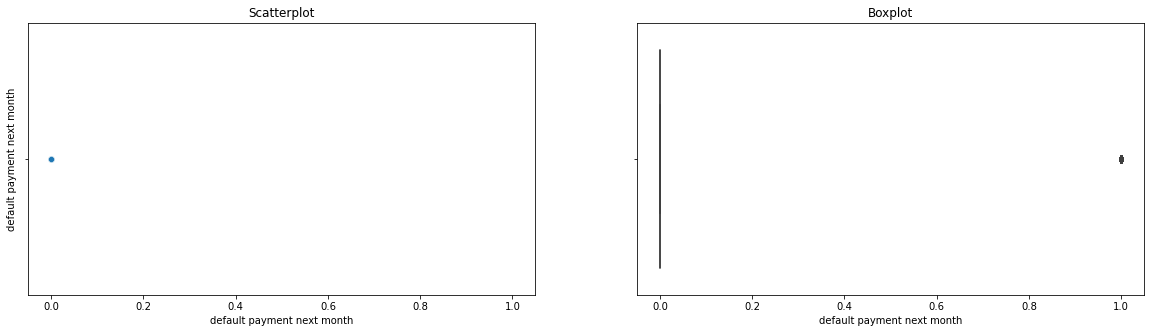

In [15]:
for column in clients.select_dtypes(exclude=['object']).columns:
    fig, axes = plt.subplots(ncols=2 , figsize=(20,5),sharey=True)
    sns.scatterplot(data=clients, x=column, y="default payment next month", ax=axes[0])
    sns.boxplot(x=clients[column], ax=axes[1])
    axes[0].set_title('Scatterplot')
    axes[1].set_title('Boxplot')
    plt.show()

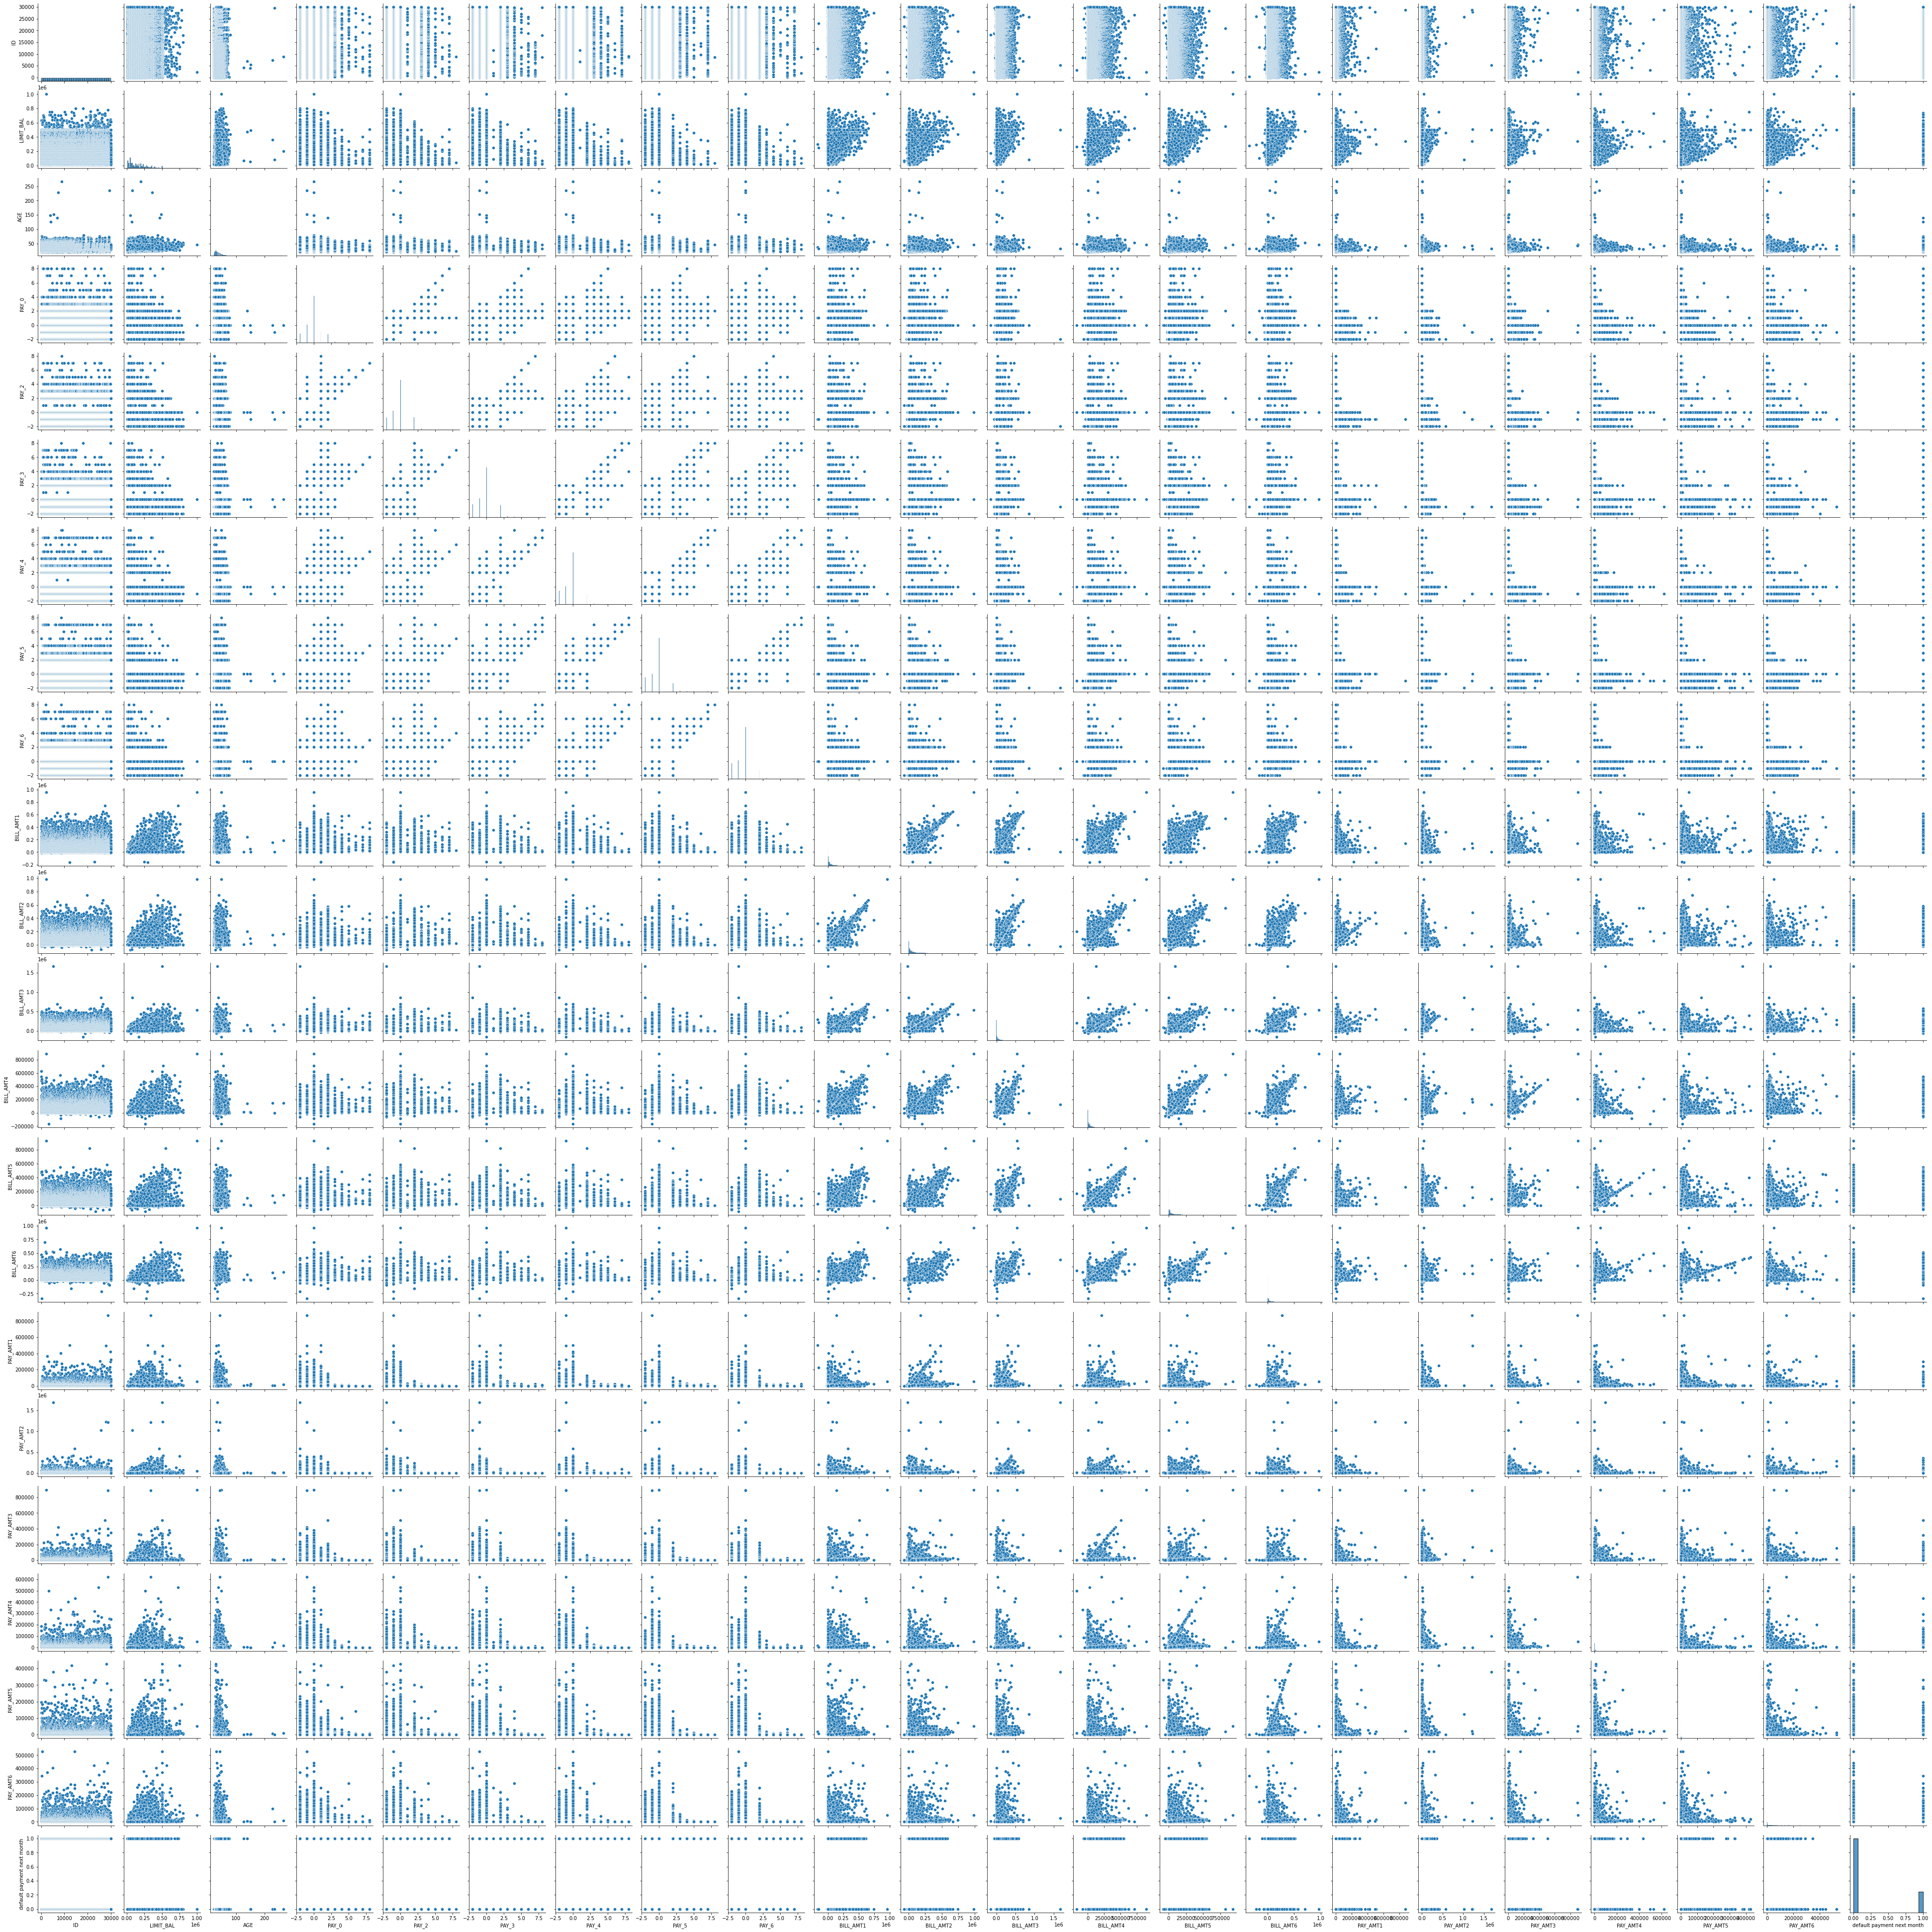

In [16]:
sns.pairplot(clients)

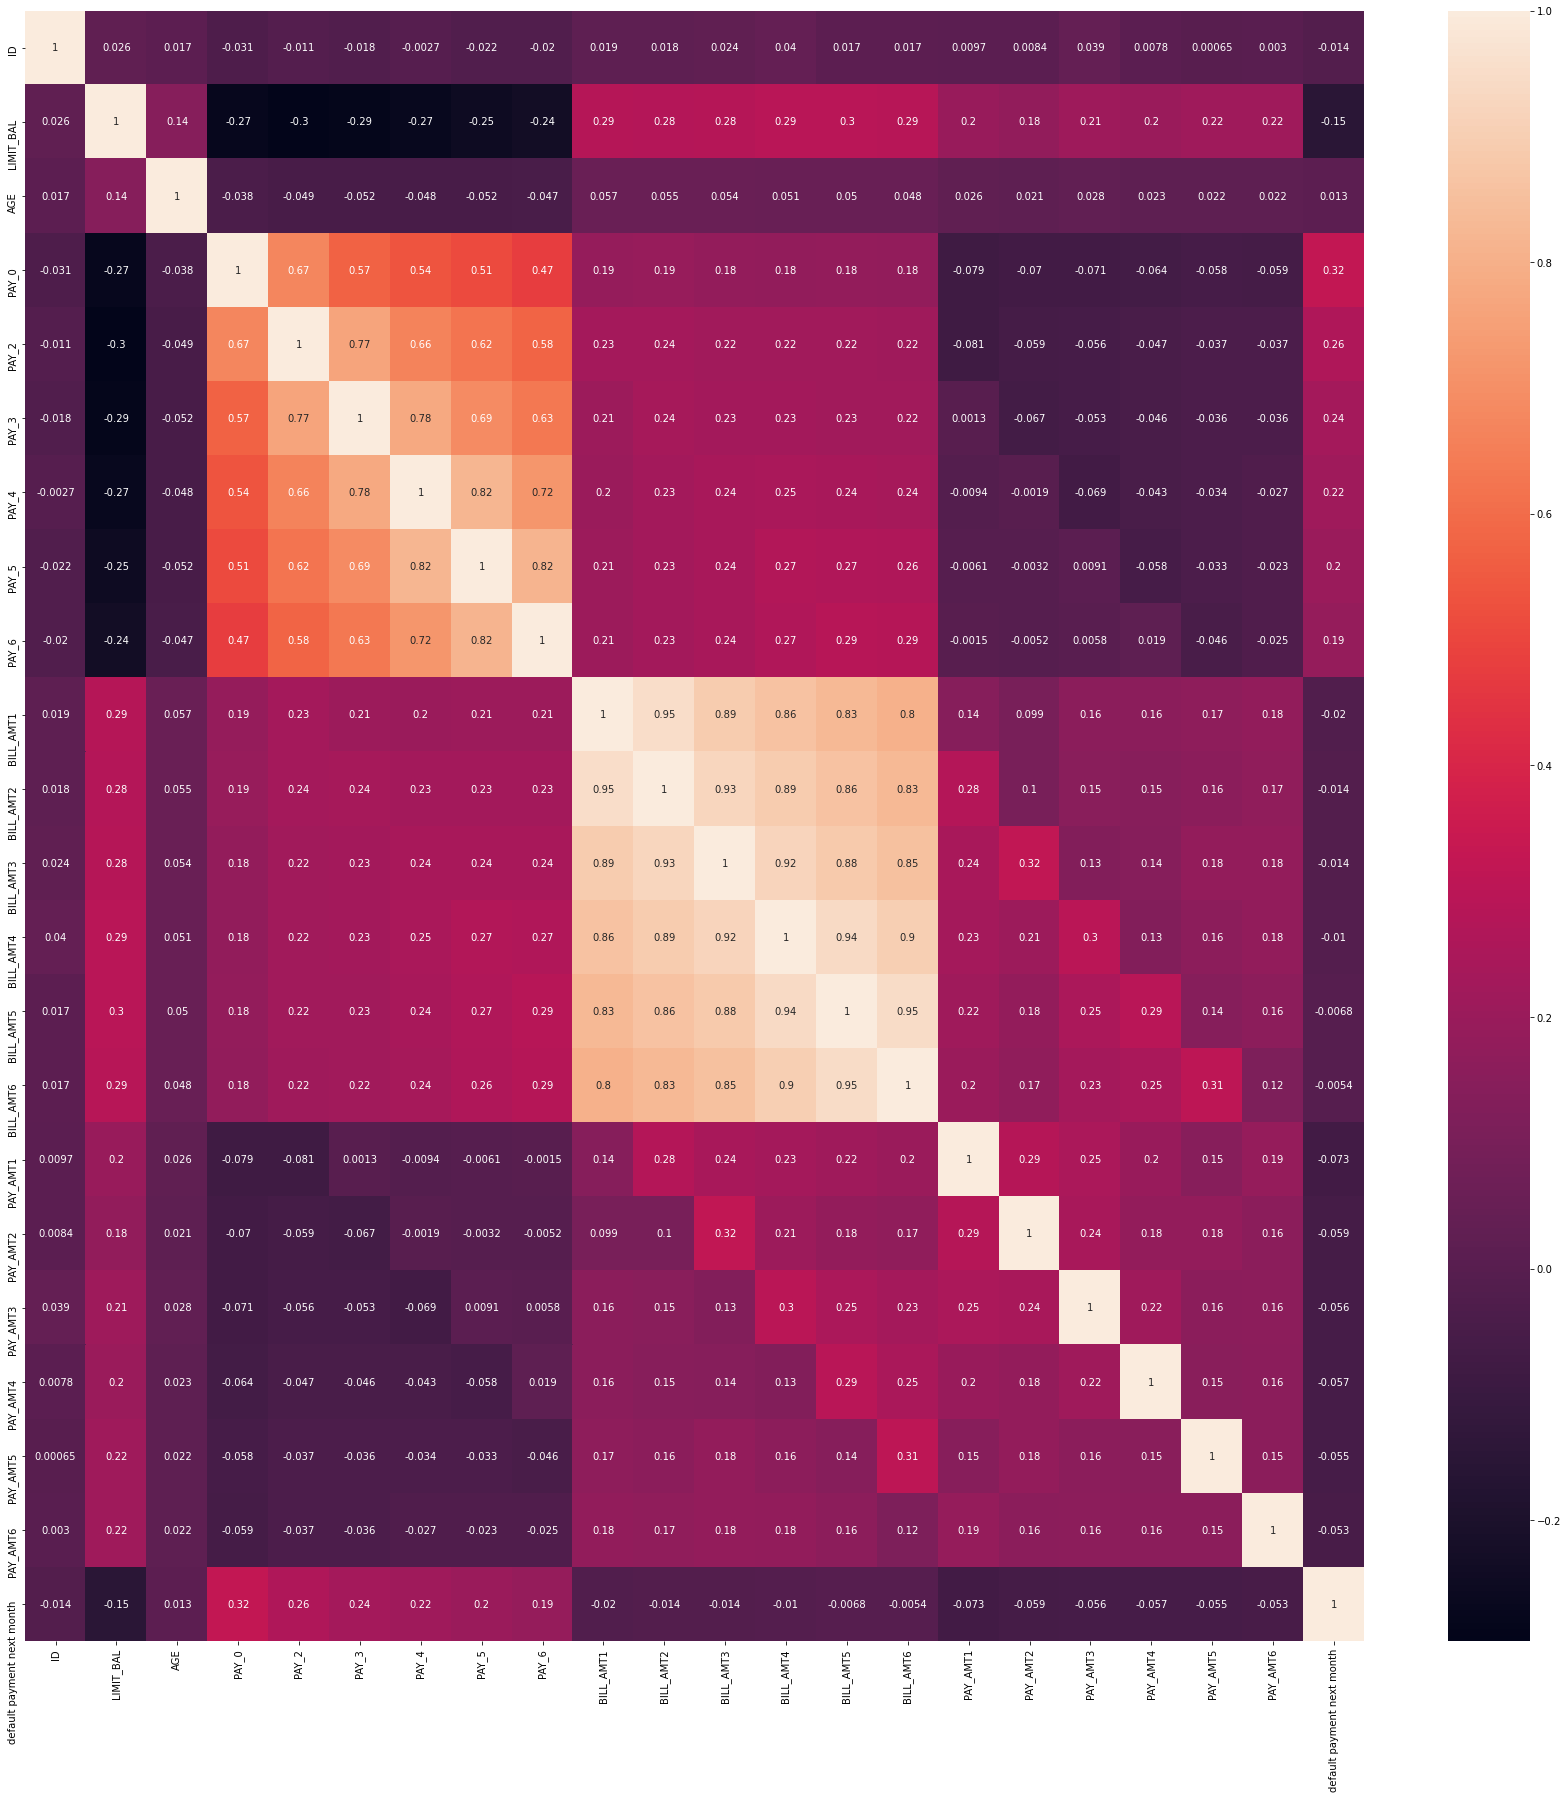

In [17]:
f, ax = plt.subplots(figsize=(30, 30))
corr = clients.corr()
mp = sns.heatmap(corr, ax=ax, annot = True)

## <a name="3">3. Prepare the data for Machine Learning algorithms</a>
(<a href="#0">Go to top</a>)

In [18]:
#drop unused columns
clients.drop(columns=['ID'], inplace=True)

In [19]:
#rename the target column and PAY_0 column
clients.rename(columns = {'default payment next month': 'y', 'PAY_0':'PAY_1' }, inplace=True)

In [20]:
clients.head()

LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0      20000  female  university  married   24      2      2     -1     -1   
1     120000  female  university   single   26     -1      2      0      0   
2      90000  female  university   single   34      0      0      0      0   
3      50000  female  university  married   37      0      0      0      0   
4      50000    male  university  married   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  y  
0          0         0       689         0         0         0         0  1  
1       3261         0      1000      1000      1000         0      2000  1  
2      15549      1518      1500      1000      1000      1000      5000  0  
3      29547      2000      2019      1200      1100      1069      1000  0  
4      19131      2000     36681     10000      9000       689       679  0

**Impute some values**

In [21]:
clients.EDUCATION.replace({0: 'others', None :'others'}, inplace=True)
clients.MARRIAGE.replace({0: 'single', None :'single'}, inplace=True)

In [22]:
clients.isnull().sum(axis = 0)

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
y            0
dtype: int64

**Encoding Categorical Variables**

In [23]:
clients.SEX = clients.SEX.map({'female':0, 'male':1})
clients.MARRIAGE = clients.MARRIAGE.map({'single':0, 'married':1})

clients = pd.get_dummies(clients)

In [24]:
clients.head()

LIMIT_BAL  SEX  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  \
0      20000    0         1   24      2      2     -1     -1     -2     -2   
1     120000    0         0   26     -1      2      0      0      0      2   
2      90000    0         0   34      0      0      0      0      0      0   
3      50000    0         1   37      0      0      0      0      0      0   
4      50000    1         1   57     -1      0     -1      0      0      0   

   BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0       3913       3102        689          0          0          0         0   
1       2682       1725       2682       3272       3455       3261         0   
2      29239      14027      13559      14331      14948      15549      1518   
3      46990      48233      49291      28314      28959      29547      2000   
4       8617       5670      35835      20940      19146      19131      2000   

   PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  y  \
0       689         0         0         0         0  1   
1      1000      1000      1000         0      2000  1   
2      1500      1000      1000      1000      5000  0   
3      2019      1200      1100      1069      1000  0   
4     36681     10000      9000       689       679  0   

   EDUCATION_graduate school  EDUCATION_high school  EDUCATION_others  \
0                          0                      0                 0   
1                          0                      0                 0   
2                          0                      0                 0   
3                          0                      0                 0   
4                          0                      0                 0   

   EDUCATION_university  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

**Impute The Outliers**

In [25]:
Q1 = clients.quantile(0.25)
Q3 = clients.quantile(0.75)
IQR = Q3 - Q1
min_outliers = Q1 - 1.5 * IQR
max_outliers = Q3 + 1.5 * IQR

In [26]:
max_outliers

LIMIT_BAL                    525000.000
SEX                               2.500
MARRIAGE                          2.500
AGE                              60.500
PAY_1                             1.500
PAY_2                             1.500
PAY_3                             1.500
PAY_4                             1.500
PAY_5                             1.500
PAY_6                             1.500
BILL_AMT1                    162389.375
BILL_AMT2                    155538.500
BILL_AMT3                    146412.500
BILL_AMT4                    132774.875
BILL_AMT5                    122831.750
BILL_AMT6                    121111.625
PAY_AMT1                      11015.000
PAY_AMT2                      11250.500
PAY_AMT3                      10677.500
PAY_AMT4                       9589.125
PAY_AMT5                       9700.000
PAY_AMT6                       9823.375
y                                 0.000
EDUCATION_graduate school         2.500
EDUCATION_high school             0.000


In [27]:
min_outliers

LIMIT_BAL                   -235000.000
SEX                              -1.500
MARRIAGE                         -1.500
AGE                               8.500
PAY_1                            -2.500
PAY_2                            -2.500
PAY_3                            -2.500
PAY_4                            -2.500
PAY_5                            -2.500
PAY_6                            -2.500
BILL_AMT1                    -91739.625
BILL_AMT2                    -88547.500
BILL_AMT3                    -83581.500
BILL_AMT4                    -75942.125
BILL_AMT5                    -70878.250
BILL_AMT6                    -70657.375
PAY_AMT1                      -5009.000
PAY_AMT2                      -5417.500
PAY_AMT3                      -5782.500
PAY_AMT4                      -5279.875
PAY_AMT5                      -5416.000
PAY_AMT6                      -5705.625
y                                 0.000
EDUCATION_graduate school        -1.500
EDUCATION_high school             0.000


In [28]:
outliers_col = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

In [29]:
max_outliers2 = pd.Series({'LIMIT_BAL':700000,
                           'AGE':79 ,
                           'BILL_AMT1':500000,
                          'BILL_AMT2':500000,
                          'BILL_AMT3':500000,
                          'BILL_AMT4':500000,
                          'BILL_AMT5':500000,
                          'BILL_AMT6':500000,
                          'PAY_AMT1':500000,
                          'PAY_AMT2':500000,
                          'PAY_AMT3':500000,
                          'PAY_AMT4':500000,
                          'PAY_AMT5':500000,
                          'PAY_AMT6':500000})

In [30]:
min_outliers2 = pd.Series({'LIMIT_BAL':0,
                           'AGE':18 ,
                          'BILL_AMT1':0,
                          'BILL_AMT2':0,
                          'BILL_AMT3':0,
                          'BILL_AMT4':0,
                          'BILL_AMT5':0,
                          'BILL_AMT6':0,
                          'PAY_AMT1':0,
                          'PAY_AMT2':0,
                          'PAY_AMT3':0,
                          'PAY_AMT4':0,
                          'PAY_AMT5':0,
                          'PAY_AMT6':0})

In [31]:
for col in outliers_col:
    clients[col][(clients[col] < min_outliers2[col])|(clients[col] > max_outliers2[col])] = None

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [32]:
clients.isnull().sum()

LIMIT_BAL                     23
SEX                            0
MARRIAGE                       0
AGE                            7
PAY_1                          0
PAY_2                          0
PAY_3                          0
PAY_4                          0
PAY_5                          0
PAY_6                          0
BILL_AMT1                    635
BILL_AMT2                    706
BILL_AMT3                    678
BILL_AMT4                    695
BILL_AMT5                    669
BILL_AMT6                    697
PAY_AMT1                       2
PAY_AMT2                       5
PAY_AMT3                       3
PAY_AMT4                       2
PAY_AMT5                       0
PAY_AMT6                       2
y                              0
EDUCATION_graduate school      0
EDUCATION_high school          0
EDUCATION_others               0
EDUCATION_university           0
dtype: int64

In [33]:
imputer = KNNImputer(n_neighbors=5)
clients = pd.DataFrame(data=imputer.fit_transform(clients), columns=clients.columns)

In [34]:
scaler = MinMaxScaler()
scaled_clients = scaler.fit_transform(clients)
clients = pd.DataFrame(scaled_clients, columns=clients.columns)

In [35]:
clients.head()

LIMIT_BAL  SEX  MARRIAGE       AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  \
0   0.014493  0.0       1.0  0.051724    0.4    0.4    0.1    0.1    0.0   
1   0.159420  0.0       0.0  0.086207    0.1    0.4    0.2    0.2    0.2   
2   0.115942  0.0       0.0  0.224138    0.2    0.2    0.2    0.2    0.2   
3   0.057971  0.0       1.0  0.275862    0.2    0.2    0.2    0.2    0.2   
4   0.057971  1.0       1.0  0.620690    0.1    0.2    0.1    0.2    0.2   

   PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
0    0.0   0.007835   0.006210   0.001378   0.000000   0.000000   0.000000   
1    0.4   0.005370   0.003454   0.005365   0.006591   0.007007   0.006534   
2    0.2   0.058542   0.028083   0.027121   0.028870   0.030317   0.031154   
3    0.2   0.094083   0.096565   0.098595   0.057039   0.058733   0.059201   
4    0.2   0.017253   0.011352   0.071679   0.042184   0.038831   0.038331   

   PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6    y  \
0  0.000000  0.001658  0.000000  0.000000  0.000000  0.000000  1.0   
1  0.000000  0.002406  0.002395  0.002012  0.000000  0.004515  1.0   
2  0.003077  0.003610  0.002395  0.002012  0.002345  0.011287  0.0   
3  0.004054  0.004859  0.002874  0.002213  0.002506  0.002257  0.0   
4  0.004054  0.088271  0.023947  0.018109  0.001615  0.001533  0.0   

   EDUCATION_graduate school  EDUCATION_high school  EDUCATION_others  \
0                        0.0                    0.0               0.0   
1                        0.0                    0.0               0.0   
2                        0.0                    0.0               0.0   
3                        0.0                    0.0               0.0   
4                        0.0                    0.0               0.0   

   EDUCATION_university  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0

## <a name="4">4. Select a model and train it</a>
(<a href="#0">Go to top</a>)

**Splitting the data**

In [36]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'

role = get_execution_role()

In [37]:
clients = pd.concat([clients['y'], clients.drop(['y'], axis=1)], axis=1)

In [38]:
train_data, validation_data, test_data = np.split(clients.sample(frac=1, random_state=1729), [int(0.7 * len(clients)), int(0.9 * len(clients))])

In [39]:
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)

In [40]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [41]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

**XGBoost Model**

In [42]:
container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name, '1.0-1')

In [43]:
hyperparameters = {'max_depth':5,
                  'eta':0.2,
                  'gamma':4,
                  'min_child_weight':6,
                  'subsample':0.8,
                  'silent':0,
                  'objective':'binary:logistic',
                  'num_round':100}

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    hyperparameters=hyperparameters,
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-04-01 01:31:30 Starting - Starting the training job...
2021-04-01 01:31:55 Starting - Launching requested ML instancesProfilerReport-1617240690: InProgress
.........
2021-04-01 01:33:15 Starting - Preparing the instances for training......
2021-04-01 01:34:18 Downloading - Downloading input data
2021-04-01 01:34:18 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[01:35:07] 21000x26 matrix with 546000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&del

In [44]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           serializer=CSVSerializer(),
                           instance_type='ml.m4.xlarge')

---------------!

In [45]:
def predict(predictor, features, labels):
    """
    predictor : Predictor object of model
    features: Input features to model
    label: Ground truth target values
    """
    
    predictions = np.round(np.fromstring(predictor.predict(features).decode('utf-8'), sep=','))
    
    accuracy = (predictions == labels).sum() / labels.shape[0]
    print(f'Accuracy: {accuracy}')
    
    auc = roc_auc_score(labels, predictions)
    print(f'AUC     : {auc}')
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, predictions, average = 'binary')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1_score: {f1_score}')
    
    confusion_matrix = pd.crosstab(index=labels, columns=predictions, rownames=['Actual'], colnames=['Predicted']).astype(int)
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap="YlGnBu").set_title('Confusion Matrix') 


Accuracy: 0.8243333333333334
AUC     : 0.666025641025641
Precision: 0.67828418230563
Recall: 0.38333333333333336
F1_score: 0.4898354307841239


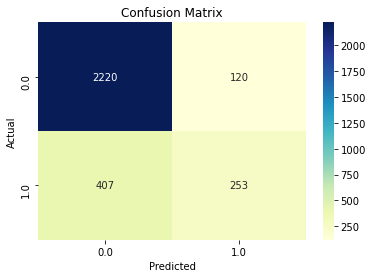

In [46]:
predict(xgb_predictor, test_data.drop(['y'], axis=1).values, test_data.y.values)

## 5. <a name="5">Fine-tune your model</a>
(<a href="#0">Go to top</a>)

In [47]:
hyperparameters2 = {'objective':'binary:logistic',
                   'num_round':10}


xgb2 = sagemaker.estimator.Estimator(container,
                                     role,
                                     hyperparameters=hyperparameters2,
                                     instance_count=1,
                                     instance_type='ml.m4.xlarge',
                                     output_path='s3://{}/{}/output'.format(
                                        bucket, prefix),
                                     sagemaker_session=sess)

In [48]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

hyperparameter_ranges = {
    'eta': ContinuousParameter(0, 1),
    'min_child_weight': IntegerParameter(1, 10)

}

In [49]:
objective_metric_name='validation:error'

In [50]:
tuner = HyperparameterTuner(estimator=xgb2,
                            objective_metric_name=objective_metric_name,
                            hyperparameter_ranges=hyperparameter_ranges,
                            objective_type='Minimize',
                            max_jobs=9,
                            max_parallel_jobs=3)

In [51]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

................................................................................................................................................................................!


## 6. <a name="6">Deploy the new trained model</a>
(<a href="#0">Go to top</a>)

In [52]:
# Create a SageMaker model from the best model
model_name = sess.create_model_from_job(training_job_name=tuner.best_training_job(),
                                        role=role)

In [54]:
sage_client = sess.sagemaker_client

# Get the current endpoint configuration
endpoint = sage_client.describe_endpoint(EndpointName=xgb_predictor.endpoint_name)
endpoint_config = sage_client.describe_endpoint_config(
    EndpointConfigName=endpoint['EndpointConfigName'])

# Change the current deployment weight to 0.5 (we'll move 50% of the traffic to the new model)
current_model_config = endpoint_config['ProductionVariants'][0]
current_model_config['InitialVariantWeight'] = 0.5
current_model_config['VariantName'] = 'XGBoost'


# Variant = 'TunedXGBoost'
tuned_model_config = {'ModelName': model_name,
                      'InitialInstanceCount': 1,
                      'InstanceType': 'ml.m4.xlarge',
                      'VariantName': 'TunedXGBoost',
                      'InitialVariantWeight': 1}


# Create the new endpoint configuration
sage_client.create_endpoint_config(
    EndpointConfigName='AB-Config',
    ProductionVariants=[current_model_config,
                        tuned_model_config])

# Update the endpoint
sage_client.update_endpoint(
    EndpointName=endpoint['EndpointConfigName'],
    EndpointConfigName='AB-Config'
)
result = sess.wait_for_endpoint(endpoint['EndpointConfigName'])

-----------------!

**Test the new model with 50% traffic**

Accuracy: 0.8243333333333334
AUC     : 0.666025641025641
Precision: 0.67828418230563
Recall: 0.38333333333333336
F1_score: 0.4898354307841239


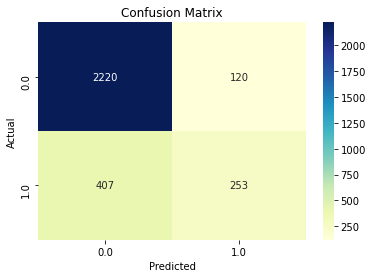

In [55]:
predict(xgb_predictor, test_data.drop(['y'], axis=1).values, test_data.y.values)

**Sending all traffic to the new model**

In [56]:
sage_client.update_endpoint_weights_and_capacities(
    EndpointName=endpoint['EndpointConfigName'],
    DesiredWeightsAndCapacities=[
        {
            'VariantName': 'TunedXGBoost',
            'DesiredWeight': 1
        },
        {
            'VariantName': 'XGBoost',
            'DesiredWeight': 0
        }
    ]
)
response = sess.wait_for_endpoint(endpoint['EndpointConfigName'])

---!

Accuracy: 0.8236666666666667
AUC     : 0.6596153846153846
Precision: 0.6855524079320113
Recall: 0.36666666666666664
F1_score: 0.4777887462981244


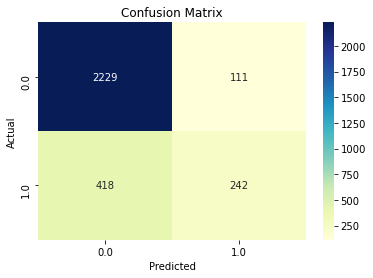

In [57]:
predict(xgb_predictor, test_data.drop(['y'], axis=1).values, test_data.y.values)

**Delete the endpoint**

In [58]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint_name)